# Decision Tree Exercises

In [21]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph
from env import host, user, password
import acquire

In [2]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test

In [3]:
# Acquire
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


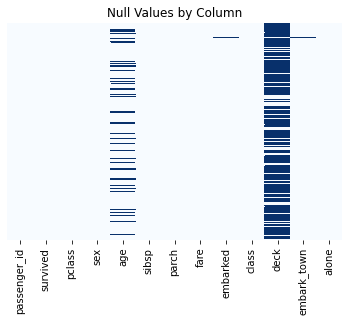

In [4]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap='Blues')

plt.title('Null Values by Column')
plt.show()

In [5]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [6]:
round(df.isna().mean() * 100, 2)

passenger_id     0.00
survived         0.00
pclass           0.00
sex              0.00
age             19.87
sibsp            0.00
parch            0.00
fare             0.00
embarked         0.22
class            0.00
deck            77.22
embark_town      0.22
alone            0.00
dtype: float64

In [7]:
#encode and concat
get_dummies = pd.get_dummies(df[['embark_town', 'sex']], drop_first=True)
get_dummies.sample(5)
df = pd.concat([df, get_dummies], axis=1)
df.sample(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
740,740,1,1,male,NaN,0,0,30.00,S,First,D,Southampton,1,0,1,1
452,452,0,1,male,30.0,0,0,27.75,C,First,C,Cherbourg,1,0,0,1


In [8]:
#drop columns
df = df.drop(columns=['deck', 'passenger_id', 'embarked','age', 'class'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 891 non-null    int64  
 1   pclass                   891 non-null    int64  
 2   sex                      891 non-null    object 
 3   sibsp                    891 non-null    int64  
 4   parch                    891 non-null    int64  
 5   fare                     891 non-null    float64
 6   embark_town              889 non-null    object 
 7   alone                    891 non-null    int64  
 8   embark_town_Queenstown   891 non-null    uint8  
 9   embark_town_Southampton  891 non-null    uint8  
 10  sex_male                 891 non-null    uint8  
dtypes: float64(1), int64(5), object(2), uint8(3)
memory usage: 58.4+ KB


In [9]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.survived)

In [10]:
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.survived)

In [11]:
# We will be attempting to make a decision tree classifier model that will predict survival on the titanic that performs better than the baseline

In [12]:
train.head()

,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
583,0,1,male,0,0,40.1250,Cherbourg,1,0,0,1
165,1,3,male,0,2,20.5250,Southampton,0,0,1,1
50,0,3,male,4,1,39.6875,Southampton,0,0,1,1
259,1,2,female,0,1,26.0000,Southampton,0,0,1,0
306,1,1,female,0,0,110.8833,Cherbourg,1,0,0,0


### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [13]:
#get mode from survial counts
train.survived.value_counts()
#baseline is 0 = did not survive

0    307
1    191
Name: survived, dtype: int64

In [14]:
train['baseline'] = 0 #column that is just zeros bc that is the assumption determined from the mode


In [15]:
print(f'Baseline Accuracy is {(train.baseline == train.survived).mean():.3}')

Baseline Accuracy is 0.616


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [16]:
#create model then fit

In [22]:
clf1 = DecisionTreeClassifier() #max dept default to compare against

In [23]:
train.drop(columns='baseline', inplace=True)

KeyError: "['baseline'] not found in axis"

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [24]:
X_train = train.drop(columns='survived') #everything in the df that is not
y_train = train.survived

In [25]:
clf1.fit(X_train, y_train)

ValueError: could not convert string to float: 'male'

In [ ]:
y_pred = clf1.predict(X_train)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
#model score accuracy

In [ ]:
accuracy = clf1.score(X_train, y_train)

In [ ]:
accuracy

In [ ]:
#confusion matrix

In [ ]:
conf = confusion_matrix(y_train, y_pred)

In [ ]:
conf

### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [ ]:
class_report = classification_report(y_train, y_pred, output_dict=True)

In [ ]:
pd.DataFrame(class_report).rename({'0': 'death', '1': 'survived'}).T

In [ ]:
conf_df = pf.DataFrame(conf, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])

In [ ]:
cond_df

In [28]:
rubric_df = conf_df = pd.DataFrame([['true negative', 'false positive'],['false negative', 'true positive']], columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])
rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [ ]:
joined = pd.concat([conf_df, rubric_df, axis=1])

In [ ]:
# create a function to calculate these metrics
def get_metrics_binary():
    accuracy = clf1.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    tpr = conf[1][1]/conf[1].sum()
    fpr = conf[0][1]/conf[0].sum()
    tnr = conf[0][0]/conf[0].sum()
    fnr = conf[1][0]/conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The TP rate is {tpr:.3}, The FP rate is {fpr:.3},
    The TN rate is {tnr:.3}, and the FN rate is {fnr:.3})

### 5. Run through steps 2-4 using a different max_depth value.

### 6. Which model performs better on your in-sample data?

### 7. Which model performs best on your out-of-sample data, the validate set?

# Random Forest

### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

### After making a few models, which one has the best performance (or closest metrics) on both train and validate?